In [1]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existin

In [2]:
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Label Mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (32, 32))    # LeNet-5는 32x32 입력 사용
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)


# dataset 분할 (train:validation = 5:1), test dataset은 emnist dataset에 있는 것으로 사용
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=47)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=47)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=47)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.WZB4LV_3.1.0/emnist-train.array_record*...:   0…

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.WZB4LV_3.1.0/emnist-test.array_record*...:   0%…

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.


In [6]:
%load_ext tensorboard

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout

tf.random.set_seed(42)
np.random.seed(42)

# LeNet-5 모델 정의 (activation function : relu)
class LeNet5_relu(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='relu', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))

# LeNet-5 모델 정의 (activation function : tanh)
class LeNet5_tanh(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='tanh', input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='tanh', padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), activation='tanh', padding='valid'))
    self.add(Flatten())
    self.add(Dense(84, activation='tanh'))
    self.add(Dropout(0.5))
    self.add(Dense(num_classes, activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 16, 16, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.5008 - loss: 1.7750 - val_accuracy: 0.8265 - val_loss: 0.5172
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7939 - loss: 0.6397 - val_accuracy: 0.8501 - val_loss: 0.4373
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8264 - loss: 0.5285 - val_accuracy: 0.8626 - val_loss: 0.3917
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8417 - loss: 0.4729 - val_accuracy: 0.8658 - val_loss: 0.3902
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8507 - loss: 0.4446 - val_accuracy: 0.8679 - val_loss: 0.3751
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8572 - loss: 0.4177 - val_accuracy: 0.8708 - val_loss: 0.3774
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8639 - loss: 0.3960 - val_accuracy: 0.8709 - val_loss: 0.3715
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8667 - loss: 0

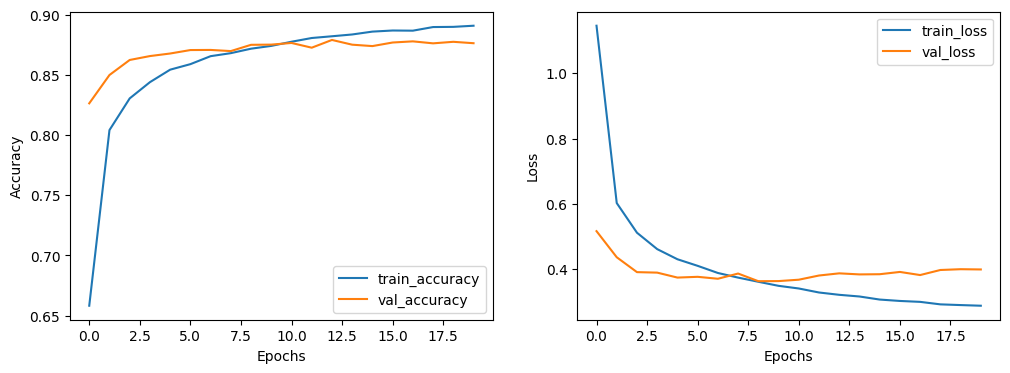

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8758 - loss: 0.4129
Test Loss: 0.4269, Test Accuracy: 0.8741
훈련시간 : 5.36 minutes.
평균 추론 시간: 0.0001 seconds.


In [7]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r1 = LeNet5_relu(input_shape,num_classes)
model_r1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_r1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.2619 - loss: 2.8115 - val_accuracy: 0.7132 - val_loss: 1.0088
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 1.3693 - val_accuracy: 0.7741 - val_loss: 0.7359
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6830 - loss: 1.0499 - val_accuracy: 0.7996 - val_loss: 0.6196
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7199 - loss: 0.8960 - val_accuracy: 0.8116 - val_loss: 0.5691
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7495 - loss: 0.7970 - val_accuracy: 0.8236 - val_loss: 0.5255
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7673 - loss: 0.7346 - val_accuracy: 0.8311 - val_loss: 0.4966
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7797 - loss: 0.6819 - val_accuracy: 0.8376 - val_loss: 0.4764
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7912 - loss: 0

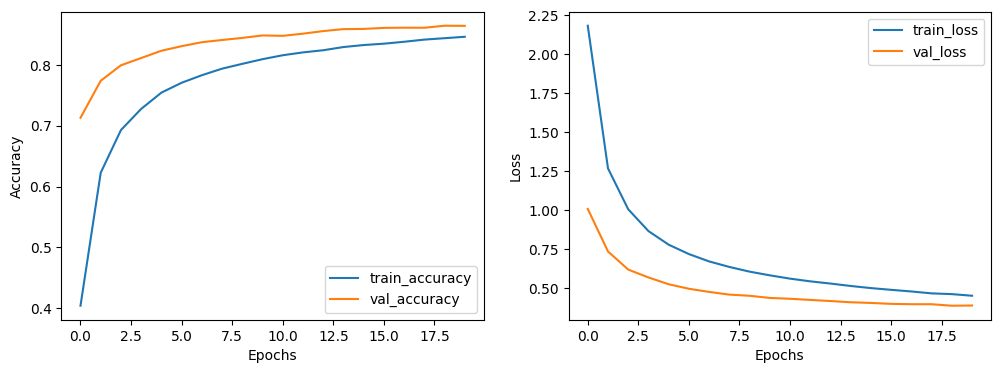

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8665 - loss: 0.3959
Test Loss: 0.4073, Test Accuracy: 0.8626
훈련시간 : 5.66 minutes.
평균 추론 시간: 0.0001 seconds.


In [8]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r2 = LeNet5_relu(input_shape,num_classes)
model_r2.summary()

# Learning rate
Learning_rate = 1e-4
model = model_r2

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_relu_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0542 - loss: 3.7661 - val_accuracy: 0.3057 - val_loss: 3.0459
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.1896 - loss: 3.0776 - val_accuracy: 0.4559 - val_loss: 2.3490
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2848 - loss: 2.6469 - val_accuracy: 0.5260 - val_loss: 1.9712
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.3466 - loss: 2.3810 - val_accuracy: 0.5693 - val_loss: 1.7390
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.3964 - loss: 2.1863 - val_accuracy: 0.6012 - val_loss: 1.5585
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.4350 - loss: 2.0420 - val_accuracy: 0.6262 - val_loss: 1.4468
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.4657 - loss: 1.9187 - val_accuracy: 0.6451 - val_loss: 1.3353
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4888 - loss: 1

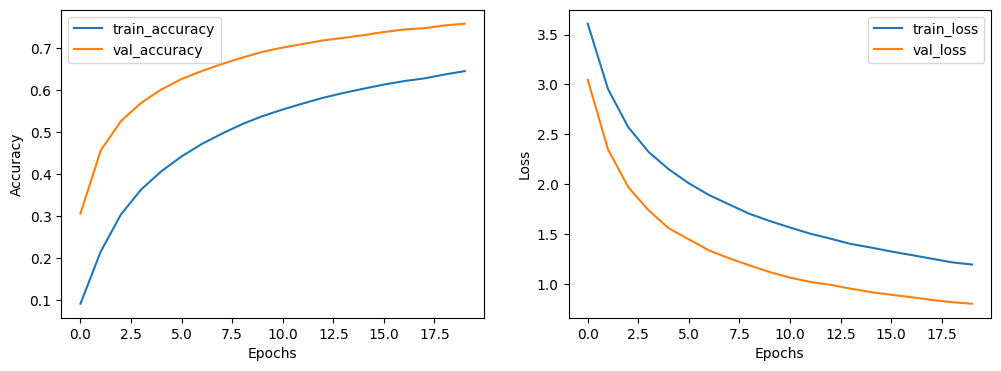

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7571 - loss: 0.8195
Test Loss: 0.8169, Test Accuracy: 0.7560
훈련시간 : 5.49 minutes.
평균 추론 시간: 0.0001 seconds.


In [9]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_r3 = LeNet5_relu(input_shape,num_classes)
model_r3.summary()

# Learning rate
Learning_rate = 1e-5
model = model_r3

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net5_tanh"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5176 - loss: 1.7368 - val_accuracy: 0.8143 - val_loss: 0.5677
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7808 - loss: 0.6859 - val_accuracy: 0.8339 - val_loss: 0.4764
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8077 - loss: 0.5837 - val_accuracy: 0.8483 - val_loss: 0.4399
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8199 - loss: 0.5431 - val_accuracy: 0.8522 - val_loss: 0.4191
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8297 - loss: 0.5139 - val_accuracy: 0.8552 - val_loss: 0.4094
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8339 - loss: 0.4952 - val_accuracy: 0.8555 - val_loss: 0.4103
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8380 - loss: 0.4817 - val_accuracy: 0.8593 - val_loss: 0.3947
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8429 - loss: 0

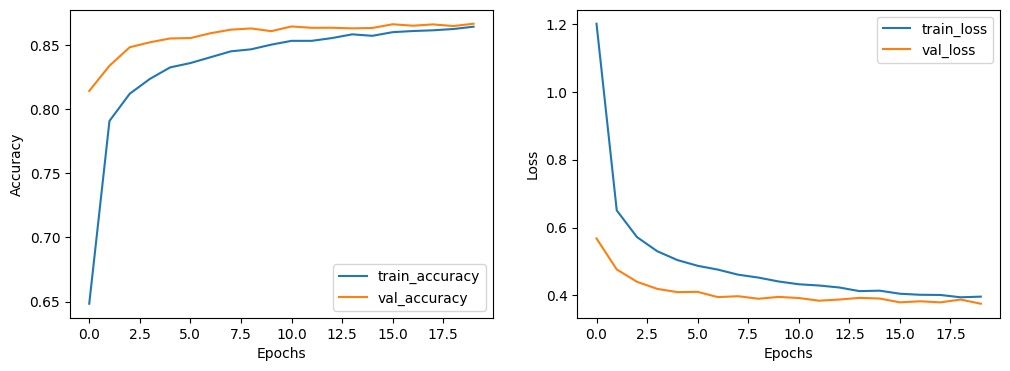

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8692 - loss: 0.3846
Test Loss: 0.3924, Test Accuracy: 0.8665
훈련시간 : 5.09 minutes.
평균 추론 시간: 0.0001 seconds.


In [10]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_t1 = LeNet5_tanh(input_shape,num_classes)
model_t1.summary()

# Learning rate
Learning_rate = 1e-3
model = model_t1

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

Model: "le_net5_tanh_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_9                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.3014 - loss: 2.7202 - val_accuracy: 0.6429 - val_loss: 1.3803
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5867 - loss: 1.5015 - val_accuracy: 0.7334 - val_loss: 0.9670
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6860 - loss: 1.0949 - val_accuracy: 0.7842 - val_loss: 0.7370
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7464 - loss: 0.8593 - val_accuracy: 0.8106 - val_loss: 0.6158
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7751 - loss: 0.7382 - val_accuracy: 0.8251 - val_loss: 0.5522
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7937 - loss: 0.6658 - val_accuracy: 0.8330 - val_loss: 0.5098
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8083 - loss: 0.6094 - val_accuracy: 0.8403 - val_loss: 0.4804
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8161 - loss: 0

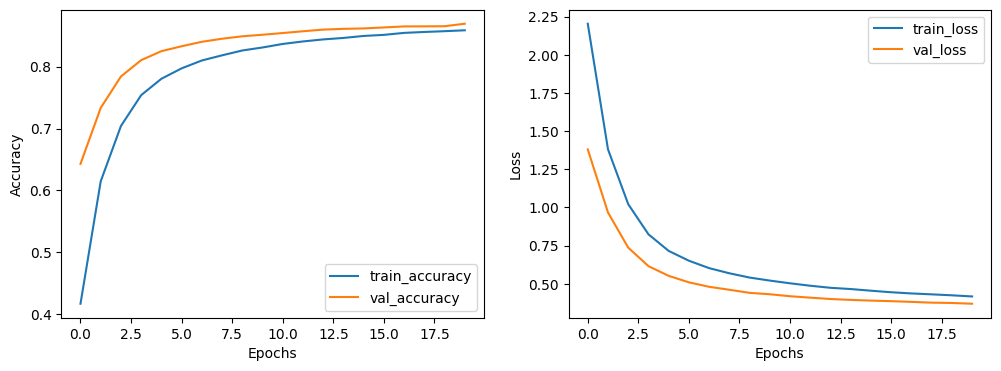

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8704 - loss: 0.3794
Test Loss: 0.3874, Test Accuracy: 0.8684
훈련시간 : 5.37 minutes.
평균 추론 시간: 0.0001 seconds.


In [11]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_t2 = LeNet5_tanh(input_shape,num_classes)
model_t2.summary()

# Learning rate
Learning_rate = 1e-4
model = model_t2

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

Model: "le_net5_tanh_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_10                 │ (None, 16, 16, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_11                 │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 2, 2, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          40,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,391 (372.62 KB)

 Trainable params: 95,391 (372.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.0918 - loss: 3.6793 - val_accuracy: 0.3760 - val_loss: 2.8199
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.2874 - loss: 2.8013 - val_accuracy: 0.4890 - val_loss: 2.3155
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.3650 - loss: 2.4499 - val_accuracy: 0.5410 - val_loss: 2.0539
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.4104 - loss: 2.2422 - val_accuracy: 0.5719 - val_loss: 1.8759
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.4482 - loss: 2.0910 - val_accuracy: 0.5954 - val_loss: 1.7391
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4782 - loss: 1.9659 - val_accuracy: 0.6144 - val_loss: 1.6274
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5069 - loss: 1.8519 - val_accuracy: 0.6310 - val_loss: 1.5314
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5274 - loss: 1

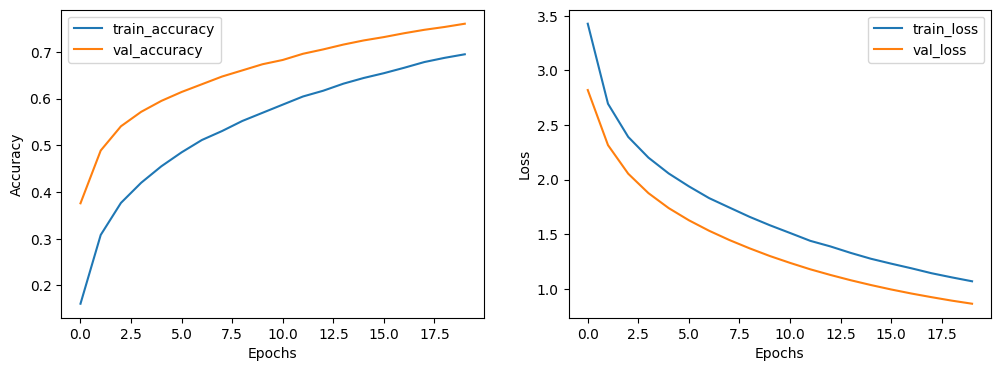

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7609 - loss: 0.8725
Test Loss: 0.8747, Test Accuracy: 0.7610
훈련시간 : 5.51 minutes.
평균 추론 시간: 0.0001 seconds.


In [12]:
input_shape = (32,32,3)
num_classes = 47

# 모델 생성
model_t3 = LeNet5_tanh(input_shape,num_classes)
model_t3.summary()

# Learning rate
Learning_rate = 1e-5
model = model_t3

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

# 모델 학습
start_time = time.time()  # 학습 시작 시간
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)
training_time = time.time() - start_time  # 학습 시간 계산

# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 평가
start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")